In [83]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sys, tqdm

plt.style.use("/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/kode/matplotlib_style/standard_plot_style.mplstyle")

import qutip

save_figures = True
save_path    = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/Figs/Results/spam_seperation_and_post_selection/"

# Load Data and Create Matched Filter
data = pd.read_csv("/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/kode/experiments/trace_data/trace_2k_10us_10ns_resolution.csv")
dt   = 10
data.head()

# Simulations:
# data = pd.read_pickle("/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/kode/readout_strategies/simulation_data/inbetween_5us_2k.pkl")

scaling_factor = 100


data.I = data.I * scaling_factor
data.Q = data.Q * scaling_factor

# Date Methods

In [84]:
def get_IQ_and_state_given_time(data, time, start_time=0):
    """
    Returns the IQ data and the state at a given time.
    """
    filtered_data = data[np.logical_and(data["t"] <= time, data["t"] >= start_time)]

    # Get the IQ data by meaning
    values = filtered_data.groupby(["trajectory"]).aggregate({"I": "mean", "Q": "mean", "initial_state": "first"})

    return values["I"].values, values["Q"].values, values["initial_state"].values




def plot_IQ_given_time(data, time, start_time=0, **kwargs):

    I, Q, states = get_IQ_and_state_given_time(data, time, start_time=start_time)

    # Plot the IQ data
    fig, ax = plt.subplots(figsize=(8, 6))

    C = ["C1" if state == 1 else "C0" for state in states]

    ax.scatter(I, Q, s=25, c = C, alpha=0.5)



def plot_IQ_given_time_and_interval(data, time, interval=1000, **kwargs):

    I, Q, states = get_IQ_and_state_given_time(data, time, start_time= time - interval)

    # Plot the IQ data
    fig, ax = plt.subplots(figsize=(8, 6))

    C = ["C1" if state == 1 else "C0" for state in states]

    ax.scatter(I, Q, s=25, c = C, alpha=0.5)

from ipywidgets import interactive, fixed

interactive_plot = interactive(plot_IQ_given_time_and_interval, data=fixed(data), time=(1000, 5000, 100), interval = fixed(1000))

interactive_plot

interactive(children=(IntSlider(value=3000, description='time', max=5000, min=1000, step=100), Output()), _dom…

# Fitting Methods

In [85]:
from scipy.stats import multivariate_normal, norm
from iminuit import Minuit

def broad_gauss(data, mu_x1, mu_y1, mu_x2, mu_y2, sigma):
    data_real = data[:, 0] - mu_x1
    data_imag = data[:, 1] - mu_y1

    angle = np.arctan2(mu_y2 - mu_y1, mu_x2 - mu_x1)
    r     = np.sqrt((mu_x2 - mu_x1) ** 2 + (mu_y2 - mu_y1) ** 2)

    data_real_rot = + data_real * np.cos(angle) + data_imag * np.sin(angle)
    data_imag_rot = - data_real * np.sin(angle) + data_imag * np.cos(angle) 

    y_gauss = norm.pdf(data_imag_rot, 0, sigma)

    x_gauss = (norm.cdf(r, data_real_rot, sigma) - norm.cdf(0, data_real_rot, sigma))  / r

    return y_gauss * x_gauss

# def double_gauss(data, args):
#     mu1_x, mu1_y, mu2_x, mu2_y, sigma, f_0, f_1 = args

#     multivariate_normal_1 = multivariate_normal([mu1_x, mu1_y], sigma ** 2 + 1e-15)
#     multivariate_normal_2 = multivariate_normal([mu2_x, mu2_y], sigma ** 2 + 1e-15)

#     pdf = f_0 * multivariate_normal_1.pdf(data) + f_1 * multivariate_normal_2.pdf(data)
    
#     return pdf 

def double_gauss_with_broad(data, args):
    mu1_x, mu1_y, mu2_x, mu2_y, sigma, f_0, f_1 = args

    multivariate_normal_1 = multivariate_normal([mu1_x, mu1_y], sigma ** 2 + 1e-15)
    multivariate_normal_2 = multivariate_normal([mu2_x, mu2_y], sigma ** 2 + 1e-15)

    pdf = f_0 * multivariate_normal_1.pdf(data) + f_1 * multivariate_normal_2.pdf(data)
    

    broad  = (1 - f_0 - f_1) * broad_gauss(data, mu1_x, mu1_y, mu2_x, mu2_y, sigma)

    return pdf + broad


def nllh(args, data):
    data = np.vstack([data.real, data.imag]).T

    pdfs = double_gauss_with_broad(data, args)
    
    args[-1] = 1 - args[-2]

    penalty = 1e3 * np.max([0, args[5] + args[6] - 1])


    if np.any(pdfs < 0):
        pdfs[pdfs<0] = 1e9

    return -2 * np.sum(np.log(pdfs + 1e-10)) + penalty


def fit_IQ_data(I, Q, guesses, limits = None):
    complex_data = I + 1j * Q
    
    minimizer = Minuit(lambda x: nllh(x, complex_data), guesses)
    
    if limits is not None:
        minimizer.limits = limits

    minimizer.migrad()

    return minimizer

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2426                       │              Nfcn = 357              │
│ EDM = 1.27e-05 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.135   │   0.013   │            │            │   -10   │   10    │       │
│ 1 │ x1   │  -1.815   │   0.012   │            │            │   -10   │   10    │       │
│ 2 │ x2   │   4.95    │   0.06    │            │            │   -10   │   10    │       │
│ 3 │ x3   │   -2.54   │   0.04    │            │            │   -10   │   10    │       │
│ 4 │ x4   │   0.347   │   0.006   │            │            │    0    │   10    │       │
│ 5 │ x5   │   0.851   │   0.013   │            │            │    0    │  0.95   │       │
│ 6 │ x6   │   0.065   │   0.010   │            │            │    0    │  0.99   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6 │
├────┼───────────────────────────────────────────────────────────────────────┤
│ x0 │  0.000158 -3.96e-06 -5.05e-05  6.48e-06  7.98e-06  2.39e-05  9.03e-06 │
│ x1 │ -3.96e-06  0.000138 -4.91e-07 -2.31e-05 -1.43e-06  -4.5e-06 -1.13e-06 │
│ x2 │ -5.05e-05 -4.91e-07   0.00353 -0.000373 -5.27e-05 -8.32e-05 -0.000282 │
│ x3 │  6.48e-06 -2.31e-05 -0.000373   0.00137  9.67e-06  1.56e-05  4.85e-05 │
│ x4 │  7.98e-06 -1.43e-06 -5.27e-05  9.67e-06  3.62e-05  9.23e-06  7.61e-06 │
│ x5 │  2.39e-05  -4.5e-06 -8.32e-05  1.56e-05  9.23e-06  0.000165 -3.98e-05 │
│ x6 │  9.03e-06 -1.13e-06 -0.000282  4.85e-05  7.61e-06 -3.98e-05  0.000106 │
└────┴───────────────────────────────────────────────────────────────────────┘

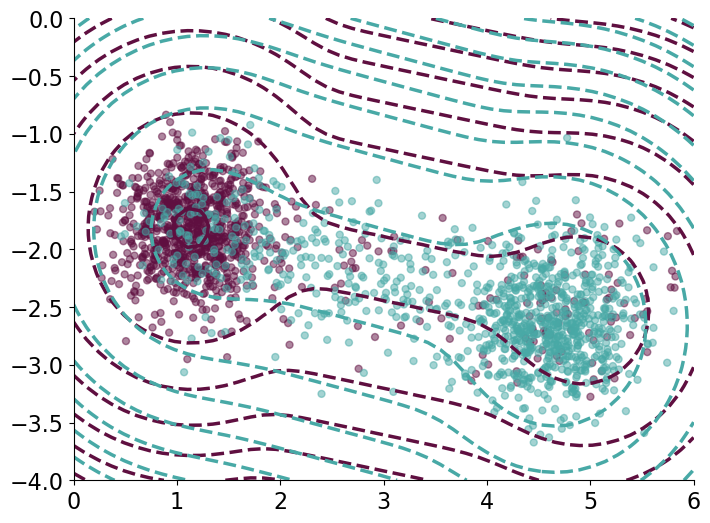

In [86]:
# I, Q, states = get_IQ_and_state_given_time(data, 5000, start_time=0)

# plot_IQ_given_time(data, 5000, start_time=0)

# guesses in the form of [mu1_x, mu1_y, mu2_x, mu2_y, sigma, f_ground, f_exited]
initial_guess_ground  = (0, -1, 5, -3, 1, 0.85, 0.05)
initial_guess_excited = (0, -1, 5, -3, 1, 0.10, 0.050)
limits                = [(-10, 10), (-10, 10), (-10, 10), (-10, 10), (0, 10), (0, 0.95), (0, 0.99)]


def fit_and_plot_given_time(data, time, start_time=0, limits = limits, plot_box = ((0, 6), (-4, 0))):
    I, Q, states = get_IQ_and_state_given_time(data, time, start_time=start_time)

    plot_IQ_given_time(data, time, start_time=start_time)

    minimizer_ground    = fit_IQ_data(I[states == 0], Q[states == 0], initial_guess_ground,  limits = limits)
    minimizer_excited   = fit_IQ_data(I[states == 1], Q[states == 1], initial_guess_excited, limits = limits)

    xs, ys = np.meshgrid(np.linspace(*plot_box[0], 50), np.linspace(*plot_box[1], 50))
    
    probs_ground    = double_gauss_with_broad(np.vstack([xs.flatten(), ys.flatten()]).T, minimizer_ground.values).reshape(xs.shape)
    probs_excited   = double_gauss_with_broad(np.vstack([xs.flatten(), ys.flatten()]).T, minimizer_excited.values).reshape(xs.shape) 

    plt.contour(xs, ys, np.log(probs_ground),  colors = "C0", levels = 10)
    plt.contour(xs, ys, np.log(probs_excited), colors = "C1", levels = 10)

    return minimizer_ground, minimizer_excited

minimizer_ground, minimzier_excited = fit_and_plot_given_time(data, 5000, start_time=200)

minimizer_ground


In [87]:
initial_guess_ground  = (0, -1, 5, -3, 1, 0.85, 0.05)
initial_guess_excited = (0, -1, 5, -3, 1, 0.10, 0.050)
limits                = [(-10, 10), (-10, 10), (-10, 10), (-10, 10), (0, 10), (0, 0.95), (0, 0.99)]

In [115]:
parameters_ground   = []
parameters_excited  = []

errors_ground       = []
errors_excited      = []

integration_durations = np.arange(1500, 5500, 500)[::-1]

guesses_ground  = initial_guess_ground
guesses_excited = initial_guess_excited

for int_dur in tqdm.tqdm(integration_durations):
    I, Q, states = get_IQ_and_state_given_time(data, int_dur, start_time= int_dur - 1000)

    # plot_IQ_given_time(data, int_dur, start_time= int_dur - 1000)

    minimizer_ground  = fit_IQ_data(I[states == 0], Q[states == 0], guesses_ground,  limits = limits)
    minimizer_excited = fit_IQ_data(I[states == 1], Q[states == 1], guesses_excited, limits = limits)

    parameters_ground.append(minimizer_ground.values)
    parameters_excited.append(minimizer_excited.values)

    errors_ground.append(minimizer_ground.errors)
    errors_excited.append(minimizer_excited.errors)

    guesses_ground = minimizer_ground.values
    guesses_excited = minimizer_excited.values

100%|██████████| 8/8 [00:02<00:00,  3.55it/s]


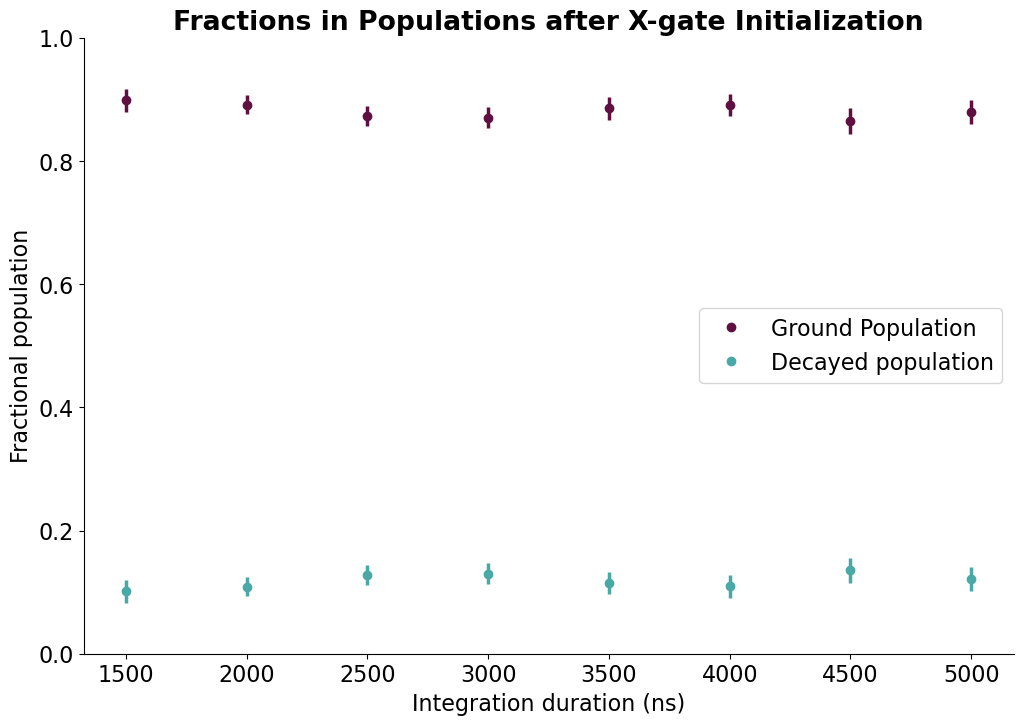

In [116]:
fig ,ax = plt.subplots()

ax.plot(integration_durations, np.array(parameters_ground)[:, 5], marker = "o", ls = "None", label = "Ground Population")
ax.errorbar(integration_durations, np.array(parameters_ground)[:, 5], np.array(errors_ground)[:, 5], color = "C0", ls = "None")
# ax.plot(integration_durations, np.array(parameters_ground)[:, 6], marker = "o", ls = "None", label = "Excited Population")
# ax.errorbar(integration_durations, np.array(parameters_ground)[:, 6], np.array(errors_ground)[:, 6], color = "C1", ls = "None")
ax.plot(integration_durations, 1 - np.array(parameters_ground)[:, 5], marker = "o", ls = "None", label = "Decayed population")
ax.errorbar(integration_durations, 1 - np.array(parameters_ground)[:, 5],np.array(errors_ground)[:, 5], color = "C1", ls = "None")

ax.set(
    xlabel = "Integration duration (ns)",
    ylabel = "Fractional population",
    title  = "Fractions in Populations after X-gate Initialization",
    ylim = (0, 1)
)

ax.legend()

In [117]:
np.array(parameters_excited)[:, 5:].sum()

7.313417268441403

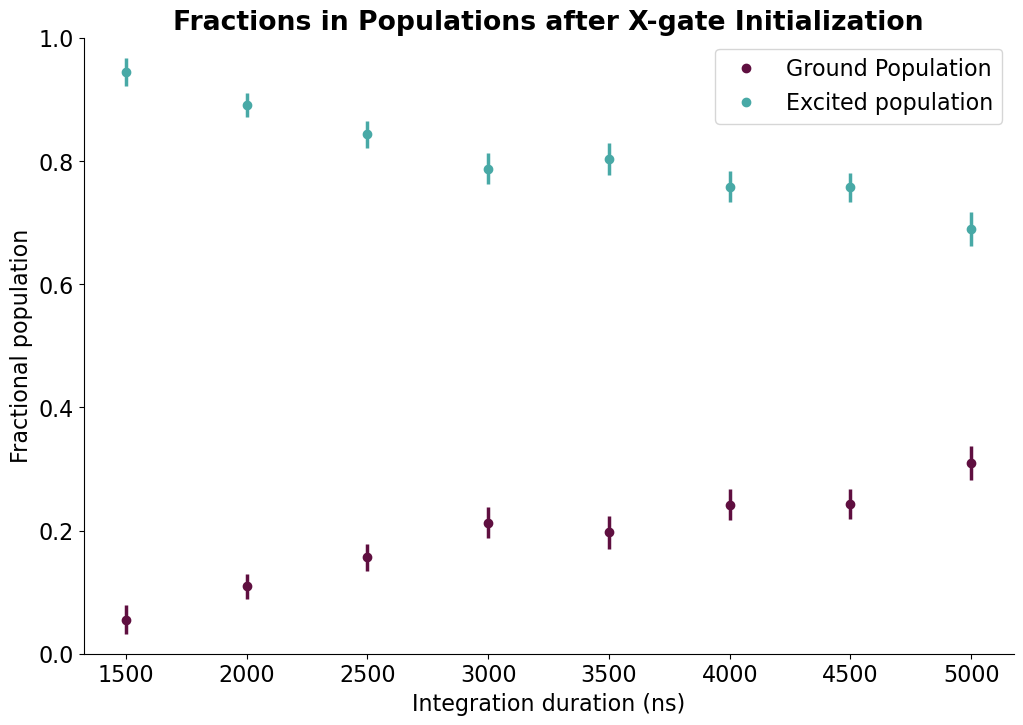

In [118]:
fig ,ax = plt.subplots()

ax.plot(integration_durations, np.array(parameters_excited)[:, 5], marker = "o", ls = "None", label = "Ground Population")
ax.errorbar(integration_durations, np.array(parameters_excited)[:, 5], np.array(errors_excited)[:, 5], color = "C0", ls = "None")
# ax.plot(integration_durations, np.array(parameters_excited)[:, 6], marker = "o", ls = "None", label = "Ground Population")
# ax.errorbar(integration_durations, np.array(parameters_excited)[:, 6], np.array(errors_excited)[:, 6], color = "C1", ls = "None")
ax.plot(integration_durations, 1 - np.array(parameters_excited)[:, 5], marker = "o", ls = "None", label = "Excited population")
ax.errorbar(integration_durations, 1 - np.array(parameters_excited)[:, 5], np.sqrt(np.array(errors_excited)[:, 5] ** 2), color = "C1", ls = "None")

ax.set(
    xlabel = "Integration duration (ns)",
    ylabel = "Fractional population",
    title  = "Fractions in Populations after X-gate Initialization",
    ylim = (0, 1)
)

ax.legend()

In [119]:
from scipy.optimize import curve_fit


offset = 500
fit_func = lambda t, frac_start, frac_end, T: (1 - frac_start) *  np.exp(- (t - offset) / T) + frac_end


from iminuit import Minuit
from iminuit.cost import LeastSquares

minimizer = Minuit(
    LeastSquares(
        integration_durations[:], 
        1 - np.array(parameters_excited)[:, 5], 
        np.array(errors_excited)[:, 5], 
        fit_func
    ), 
    T = 10000, frac_start = 0.10, frac_end = 0.20
)

minimizer.limits["T"]       = (0, np.inf)
# minimizer.limits["const"]   = (0, np.inf)
minimizer.limits["frac_start"]      = (0, 1)
minimizer.limits["frac_end"]        = (0, 1)

minimizer.migrad()


# fit_main_ground, cov_main_ground = curve_fit(
#     fit_func_main, 
#     integration_durations, 
#     np.array(parameters_ground)[:, 5], 
#     sigma = np.array(errors_ground)[:, 5], 
#     p0 = (0.5, 0.50, 0.01)
#     )

# fit_other_ground, cov_other_ground = curve_fit(fit_func_other, integration_durations, 1 - np.array(parameters_ground)[:, 6], sigma = np.array(errors_ground)[:, 6], p0 = (0.5, 0.50, 0.01))


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.47 (chi2/ndof = 0.7)     │              Nfcn = 220              │
│ EDM = 0.000141 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ frac_start │   0.55    │   0.07    │            │            │    0    │    1    │       │
│ 1 │ frac_end   │   0.63    │   0.13    │            │            │    0    │    1    │       │
│ 2 │ T          │   2.8e3   │   2.1e3   │            │            │    0    │         │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬──────────────────────────────────┐
│            │ frac_start   frac_end          T │
├────────────┼──────────────────────────────────┤
│ frac_start │    0.00553    0.00823       -111 │
│   frac_end │    0.00823     0.0179       -273 │
│          T │       -111       -273   4.29e+06 │
└────────────┴──────────────────────────────────┘

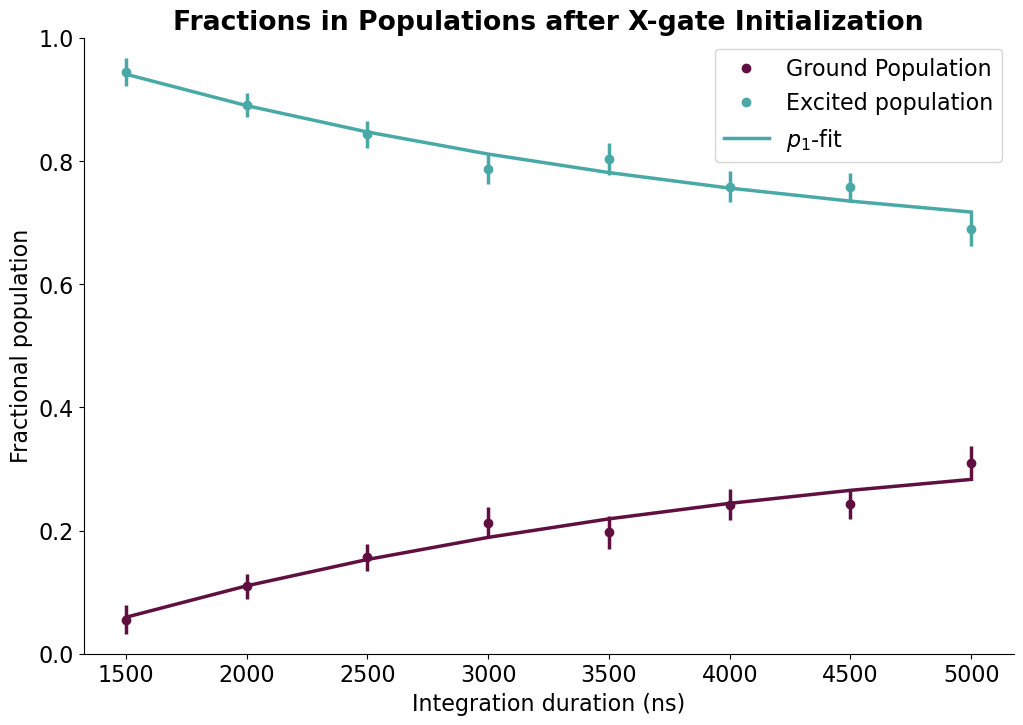

In [120]:
ax.plot(integration_durations, fit_func(integration_durations, *minimizer.values), color = "C1", label = "$p_1$-fit")
ax.plot(integration_durations, 1 - fit_func(integration_durations, *minimizer.values), color = "C0")

# ax.hlines(minimizer.values["frac"], 1500, 5000, color = "C0", ls = "--", label = "State Prep Error")

ax.legend()


fig